In [1]:
import torch
import torchaudio
import audioldm2.utilities.audio as Audio
import matplotlib.pyplot as plt
from audioldm2.latent_diffusion.modules.audiomae.AudioMAE import Vanilla_AudioMAE, AudioMAE
from audioldm2.utils import default_audioldm_config, download_checkpoint
from audioldm2.latent_diffusion.models.ddpm import LatentDiffusion
import audioldm2.utilities.audio as Audio
from audioldm2.latent_encoder.autoencoder import AutoencoderKL
%matplotlib inline
import soundfile as sf
import os
import numpy as np
# original memory used 9413MiB


/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
vae_ckpt = torch.load('vae_ckpt.pth')


In [25]:
def get_mel_from_wav(audio, _stft):
    audio = torch.clip(torch.FloatTensor(audio), -1, 1)
    audio = torch.autograd.Variable(audio, requires_grad=False)
    melspec, magnitudes, phases, energy = _stft.mel_spectrogram(audio)
    melspec = torch.squeeze(melspec, 0)
    magnitudes = torch.squeeze(magnitudes, 0)
    energy = torch.squeeze(energy, 0)
    return melspec, magnitudes, energy

def mel_spectrogram_to_waveform(self,
        mel, savepath=".", bs=None, name="outwav", save=True
    ):
        # Mel: [bs, 1, t-steps, fbins]
        if len(mel.size()) == 4:
            mel = mel.squeeze(1)
        mel = mel.permute(0, 2, 1)
        waveform = self.first_stage_model.vocoder(mel)
        waveform = waveform.cpu().detach().numpy()
        if save:
            save_waveform(self, waveform, savepath, name)
        return waveform

def mel_spectrogram_to_waveform(self,
        mel, savepath=".", bs=None, name="outwav", save=True
    ):
        # Mel: [bs, 1, t-steps, fbins]
        if len(mel.size()) == 4:
            mel = mel.squeeze(1)
        mel = mel.permute(0, 2, 1)
        waveform = self.vocoder(mel)
        waveform = waveform.cpu().detach().numpy()
        if save:
            save_waveform(self, waveform, savepath, name)
        return waveform

def save_waveform(self, waveform, savepath, name="outwav"):
    for i in range(waveform.shape[0]):
        path = os.path.join(
            savepath,
            f"{name}_{i}.wav"
        )
        
        todo_waveform = waveform[i, 0]
        todo_waveform = (
            todo_waveform / np.max(np.abs(todo_waveform))
        ) * 0.8  # Normalize the energy of the generation output
        sf.write(path, todo_waveform, samplerate=self.sampling_rate)

In [4]:
config = default_audioldm_config(model_name="audioldm2-full")

In [5]:
KLconfig = torch.load('KLconfig.pt')

In [6]:
KLconfig.get("params", dict())

{'sampling_rate': 16000,
 'batchsize': 4,
 'monitor': 'val/rec_loss',
 'image_key': 'fbank',
 'subband': 1,
 'embed_dim': 8,
 'time_shuffle': 1,
 'lossconfig': {'target': 'audioldm2.latent_diffusion.modules.losses.LPIPSWithDiscriminator',
  'params': {'disc_start': 50001,
   'kl_weight': 1000,
   'disc_weight': 0.5,
   'disc_in_channels': 1}},
 'ddconfig': {'double_z': True,
  'mel_bins': 64,
  'z_channels': 8,
  'resolution': 256,
  'downsample_time': False,
  'in_channels': 1,
  'out_ch': 1,
  'ch': 128,
  'ch_mult': [1, 2, 4],
  'num_res_blocks': 2,
  'attn_resolutions': [],
  'dropout': 0}}

In [7]:
vae = AutoencoderKL(**KLconfig.get("params", dict()))

/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [8]:
vae.load_state_dict(vae_ckpt)

<All keys matched successfully>

In [9]:
stft_config = Audio.stft.TacotronSTFT(
            config["preprocessing"]["stft"]["filter_length"],
            config["preprocessing"]["stft"]["hop_length"],
            config["preprocessing"]["stft"]["win_length"],
            config["preprocessing"]["mel"]["n_mel_channels"],
            config["preprocessing"]["audio"]["sampling_rate"],
            config["preprocessing"]["mel"]["mel_fmin"],
            config["preprocessing"]["mel"]["mel_fmax"],
        )

/workspace/data/raven/AudioLDM2/audioldm2/utilities/audio/stft.py:42: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/workspace/data/raven/AudioLDM2/audioldm2/utilities/audio/stft.py:145: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=64, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [10]:
# real audio
waveform, sr = torchaudio.load('mix_16k.wav')
waveform = waveform[:,:163872] # remove batch dim

In [11]:
waveforms = torch.cat([waveform, waveform], dim=0)

In [12]:
log_mel_spec, stft, energy = get_mel_from_wav(waveforms, stft_config)

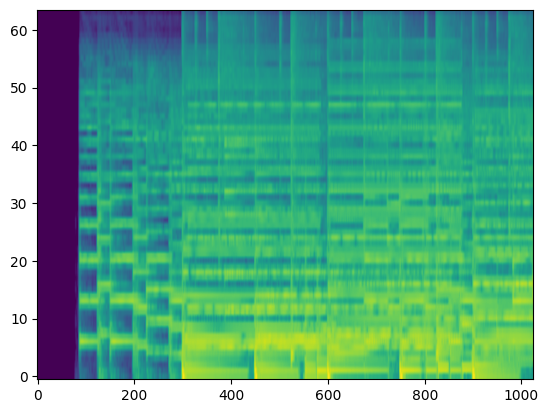

In [14]:
plt.imshow(log_mel_spec[0], aspect='auto', origin='lower')

In [18]:
log_mel_spec.shape

torch.Size([2, 64, 1025])

In [19]:
# input is supposed to have [1, 1, 1024, 64] in the original code
input = log_mel_spec.unsqueeze(1).transpose(-1,-2)
encoder_posterior = vae.encode(input)

In [20]:
z = encoder_posterior.sample()

In [21]:
mel = vae.decode(z)

In [26]:
recon_waveforms = mel_spectrogram_to_waveform(vae, mel, name='output_vae')

In [ ]:
plt.imshow(mel[0,0].T.detach().numpy(), aspect='auto', origin='lower')